This live script walks through some key elements of digital filtering

First, get some example data. 

*Make sure you have a path set in Matlab to the folder example_data, Thanks!* 


In [1]:
%matplotlib inline

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, filtfilt


In [3]:
import jupytext

In [5]:
# Read a notebook from a file
#ntbk = jupytext.read('filters.md')

# Read a notebook from a string
#jupytext.reads(text, fmt='')

In [6]:

def spatial_pattern(DIM, BETA):
    # function x = spatialPattern(DIM, BETA),
    #
    # This function generates 1/f spatial noise, with a normal error 
    # distribution (the grid must be at least 10x10 for the errors to be normal). 
    # 1/f noise is scale invariant, there is no spatial scale for which the 
    # variance plateaus out, so the process is non-stationary.
    #
    #     DIM is a two component vector that sets the size of the spatial pattern
    #           (DIM=[10,5] is a 10x5 spatial grid)
    #     BETA defines the spectral distribution. 
    #          Spectral density S(f) = N f^BETA
    #          (f is the frequency, N is normalisation coeff).
    #               BETA = 0 is random white noise.  
    #               BETA  -1 is pink noise
    #               BETA = -2 is Brownian noise
    #          The fractal dimension is related to BETA by, D = (6+BETA)/2
    # 
    # Note that the spatial pattern is periodic.  If this is not wanted the
    # grid size should be doubled and only the first quadrant used.
    #
    # Time series can be generated by setting one component of DIM to 1

    # The method is briefly descirbed in Lennon, J.L. "Red-shifts and red
    # herrings in geographical ecology", Ecography, Vol. 23, p101-113 (2000)
    #
    # Many natural systems look very similar to 1/f processes, so generating
    # 1/f noise is a useful null model for natural systems.
    #
    # The errors are normally distributed because of the central
    # limit theorem.  The phases of each frequency component are randomly
    # assigned with a uniform distribution from 0 to 2*pi. By summing up the
    # frequency components the error distribution approaches a normal
    # distribution.

    # Written by Jon Yearsley  1 May 2004
    #
    # S_f corrected to be S_f = (u.^2 + v.^2).^(BETA/2);  2/10/05
    #u = np.arange(0, np.floor(DIM[0]/2)+1)
    positive_range_u = np.arange(0, np.floor(DIM[0]/2) + 1)
    negative_range_u = np.arange(-np.ceil(DIM[0]/2) + 1, 0)
    u = np.concatenate((positive_range_u, negative_range_u)) / DIM[0]

# Transpose the resulting 1D array to a column vector.
    u = u[:, np.newaxis]
    
    # % Reproduce these frequencies along every row and transpose
    u = np.tile(u, (DIM[1],1)).T

    # % v is the set of frequencies along the second dimension.  For a square
    # % region it will be the transpose of u
    positive_range_v = np.arange(0, np.floor(DIM[1]/2) + 1)
    negative_range_v = np.arange(-np.ceil(DIM[1]/2) + 1, 0)
    v = np.concatenate((positive_range_v, negative_range_v)) / DIM[1]

    #v = [(0:floor(DIM(2)/2)) -(ceil(DIM(2)/2)-1:-1:1)]/DIM(2);
    
    # % Reproduce these frequencies along ever column
    v = np.tile(v, (DIM[0],1))
    #v = repmat(v,DIM(1),1);

    # % Generate the power spectrum
    S_f = ((u**2) + (v**2))**(BETA/2)
   
    #S_f = (u**2 + v**2)**(BETA/2);
    #S_f = (u.^2 + v.^2).^(BETA/2);

    # % Set any infinities to zero
    S_f[S_f==np.inf] = 0
    #S_f(S_f==inf) = 0;

    # % Generate a grid of random phase shifts
    phi = np.random.rand(*DIM) #asterisk (*) to unpack  DIM list to separate arguments
    #phi = rand(DIM);

    # % Inverse Fourier transform to obtain the the spatial pattern
    x = np.fft.ifft2(np.sqrt(S_f) * (np.cos(2 * np.pi * phi) + 1j * np.sin(2 * np.pi * phi)))
    #x = np.ifft2(S_f**0.5 * (np.cos(2*np.pi*phi)+1j*np.sin(2*np.pi*phi)));
    #x = ifft2(S_f.^0.5 .* (cos(2*pi*phi)+i*sin(2*pi*phi)));

    # % Pick just the real component
    x = np.real(x)
    # remove singleton dimensions # (does this work correctly with non-empty 2D?)
    x = np.squeeze(x)

    return x


We try an interesting function `spatial_pattern` *(see above)*.
                                                   
However, another way to do this is to use the following:  

- `whitesig = np.random.uniform(low=0.0, high=1.0, size=(50, 1000)) - 0.5`
  
- `brownsig= np.cumsum(whitesig)`  

In [19]:
DIM=[1,2551]
BETA=-2

 #  spatialPattern by Jon Yearsley 1 May 2004 can be used to make 1/f noise
 #  which looks like EEG

testdata= spatial_pattern([1,2551],-2);

/var/folders/j4/5b47x9f134593lnsztq6c84w4hnchz/T/ipykernel_40084/2315946131.py:63: RuntimeWarning: divide by zero encountered in reciprocal
  S_f = ((u**2) + (v**2))**(BETA/2)


Now, let's make a time axis so that we know when the event happened and plot the signal

Text(0.5, 1.0, 'Unfiltered EEG signal')

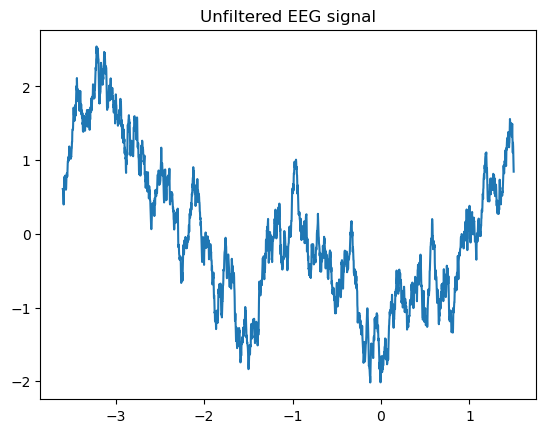

In [8]:
timeaxis = np.linspace(-3.6,1.5,2551,endpoint=True) # generate a time axis, in seconds this was sampled at 500 Hz

plt.figure()
plt.plot(timeaxis, testdata)
plt.title('Unfiltered EEG signal')


Now we make a simple Butterworth Filter at 20 Hz lowpass. 
- We use the `butter` function, the inputs are a filter order, and the cutoff, in multiples of the Nyquist frequency, which is simply half of the sample rate (500 Hz)


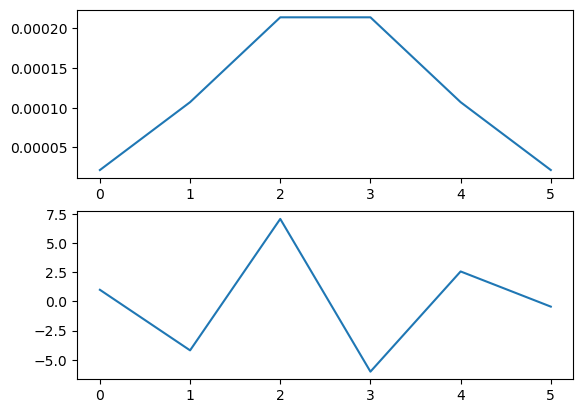

In [9]:
cutoff = 20/250
A,B = butter(5,cutoff) # this is a 5th order filter, it will have 6 values

# % let's plot the filter coefficients - i.e. the numbers that make up the filter.
plt.subplot(2,1,1)
plt.plot(A)
plt.subplot(2,1,2)
plt.plot(B)


... and now, we apply it to the data

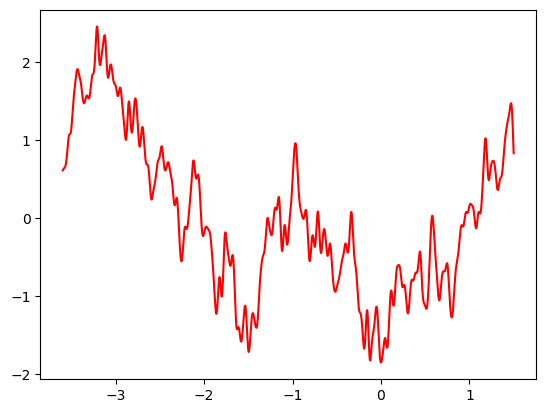

In [10]:
filtered_data = filtfilt(A,B,testdata) # this is a zero phase filter, it will have the same number of values as the input
plt.plot(timeaxis, filtered_data, 'r')
plt.show()

Now, zoom in.

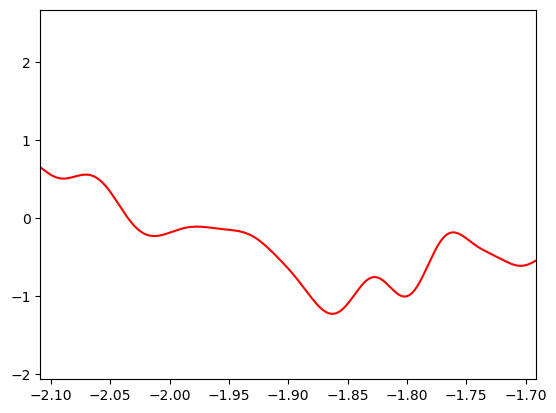

In [11]:
plt.plot(timeaxis, filtered_data, 'r')
plt.xlim([-2.109, -1.691])
# plt.ylim([-1.49, 5.9])
plt.show()

Now, we add a highpass filter at 2 Hz, same logic.

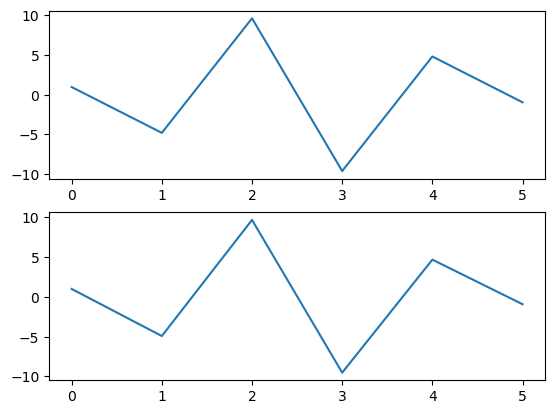

In [12]:
cutoff = 2/250
Ah,Bh = butter(5,cutoff,'high') # this is a 2nd order filter, it will have 3 values
plt.subplot(2,1,1)
plt.plot(Ah)
plt.subplot(2,1,2)
plt.plot(Bh)
plt.show()

Apply the filter and plot the signal.

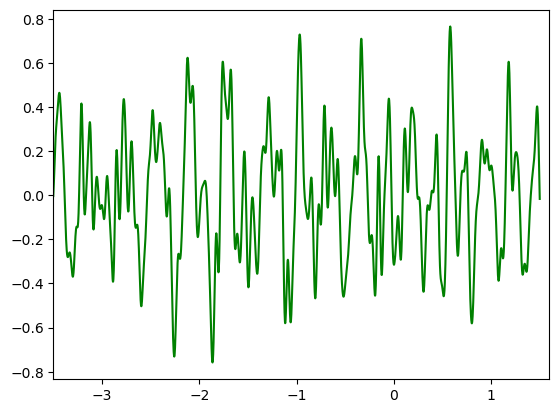

In [13]:
filtered_datah = filtfilt(Ah,Bh,filtered_data)

plt.plot(timeaxis, filtered_datah, 'g')
plt.xlim([-3.5, 1.6])
# plt.ylim([-15, 15])
plt.show()

Now, zoom in again.

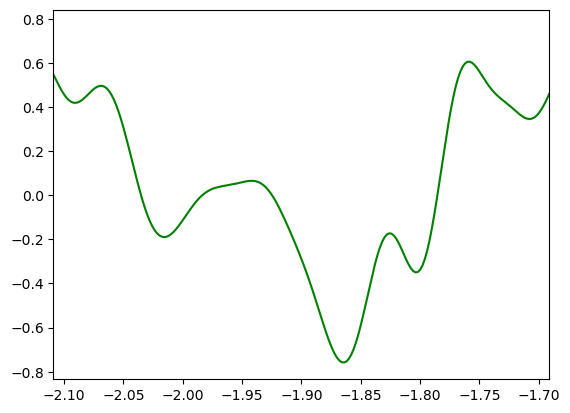

In [14]:
plt.plot(timeaxis, filtered_datah, 'g')
plt.xlim([-2.109, -1.691])
# plt.ylim([-1.49, 5.92])
plt.show()

OK, great! 
Now, how do I report on this, and what does this mean? 

To figure this out, let do a few spectra: 

In [15]:
FFT_orig = np.abs(np.fft.fft(testdata))
FFT_lp = np.abs(np.fft.fft(filtered_data))
FFT_hp = np.abs(np.fft.fft(filtered_datah))

Make a frequency axis.

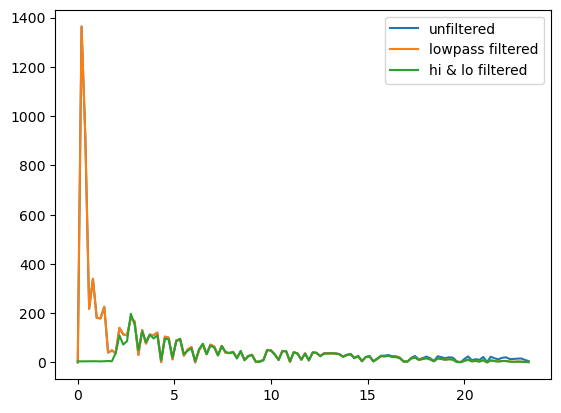

In [16]:
faxis = np.arange(0,250,1000/(len(testdata)*2)) #0.5)

plt.plot(faxis[0:120], FFT_orig[0:120])
plt.plot(faxis[0:120], FFT_lp[0:120])
plt.plot(faxis[0:120], FFT_hp[0:120])
plt.legend(['unfiltered', 'lowpass filtered', 'hi & lo filtered'])
plt.show()


Now, zoom in again.

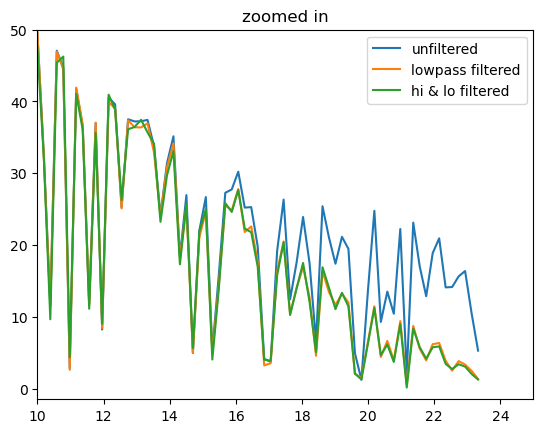

In [17]:

plt.figure()
plt.plot(faxis[0:120], FFT_orig[0:120])
plt.plot(faxis[0:120], FFT_lp[0:120])
plt.plot(faxis[0:120], FFT_hp[0:120])
plt.legend(['unfiltered', 'lowpass filtered', 'hi & lo filtered'])
plt.title('zoomed in')
plt.xlim([10, 25])
plt.ylim([-1.49, 50])
plt.show()


...and, again.

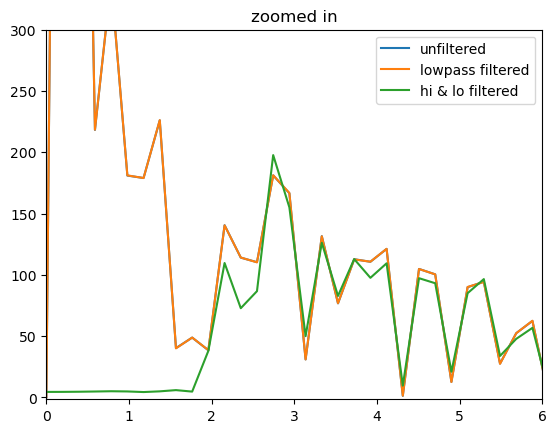

In [18]:

plt.figure()
plt.plot(faxis[0:120], FFT_orig[0:120])
plt.plot(faxis[0:120], FFT_lp[0:120])
plt.plot(faxis[0:120], FFT_hp[0:120])
plt.legend(['unfiltered', 'lowpass filtered', 'hi & lo filtered'])
plt.title('zoomed in')
plt.xlim([0, 6])
plt.ylim([-1.49, 300])
plt.show()

